3.3更新 1.修改函數名稱2.刪除舊版函數3.新torsion

3.4更新 1.新增分析部分2.修改函數名稱3.簡化代碼4.新增註解

3.5更新 1.刪除舊torsion 2.新增函數 3.新增互動部分

## 導入函式庫

In [1]:
%matplotlib inline
import numpy as np # 更快的運算
import pandas as pd # 將資料轉乘DataFrame
import matplotlib.pyplot as plt # 繪圖用
from pyquaternion import Quaternion # 用於旋轉
from ipywidgets import interact

# PDB轉成Dataframe

In [2]:
def pdb_to_df(pdb): 
    with open(pdb,'r',) as f: #開啟檔案
        lines = []
        for line in f.readlines() :
            line = line.strip() #去除/n
            line = line.split() #以空白分割
            lines.append(line) 
    df = pd.DataFrame(lines,columns = list("abcdefghijk"),dtype=np.float64) 
    # 轉成dataframe並用abcd代替上面columns，方便取出需要之編號
    df = df.loc[:, ("c","e","g","h","i")]
    df.columns = ["element","chain", "X", "Y", "Z"]
    #df.index = range(1,len(df)+1) #index改成1開始
    mask = df["element"].isin(["C","N","CA"]) #只抓取胺基酸主鍊N,CA,C
    df = df[mask] 
    df["backbone_index"] = df.index #保留原始骨架的index
    return df 

# 向量長度
向量(x, y, z)之長度為 $√(x^2+y^2+z^2)$

用於對dataframe之運算

In [3]:
def df_longth(v):
    return np.linalg.norm(v,axis=1)

用於小處之運算

In [4]:
def longth(v):
    return np.sqrt(np.sum(np.dot(v,v))) 

# 兩向量計算夾角

二維矩陣用之dot

In [5]:
def df_dot(v1, v2): 
    return np.sum(np.multiply(v1, v2), axis=1, dtype=np.float64)

因為multply只支援同大小的array故把它變成三倍,m2.T是轉置矩陣

In [6]:
def tothree(m):
    m2 = np.array([m, m, m]) 
    return m2.T # .T表示該矩陣之轉置矩陣

### 角度
Cos = dot(v1, v2)/longth(v1)*longth(v2)
但左右之cos值相同因此無法算出正負角度

In [7]:
def angle(v1, v2, l1="check", l2="check"):
    if l1 == "check" and l2 == "check": #若l1,l2沒有值再進行運算，提高速度
        cos = df_dot(v1,v2)/(df_longth(v1)*df_longth(v2)) 
    else:
        cos = df_dot(v1,v2)/(l1*l2) 
    return np.arccos(cos)

### 向量
後項XYZ-前項XYZ

In [8]:
def df_vecter(df):
    df[["VX", "VY", "VZ"]] = df.loc[:, ("X", "Y", "Z")].diff()

### 鍵長 
$√(Vx^2+Vy^2+Vz^2)$

In [9]:
def df_bond_longth(df):
    df["bond_longth"] = df_longth(df.loc[:, ("VX", "VY", "VZ")].values)

### 鍵角
$(V1·V2)/(l1*l2)$

In [10]:
def df_bond_angle(df):
    df["bond_angle"] = np.NAN
    vxyz = ("VX", "VY", "VZ")
    v1 = df.loc[1:len(df)-1, vxyz].values #1-df-1
    v2 = df.loc[2:len(df), vxyz].values
    l1 = df.loc[1:len(df)-1, "bond_longth"].values
    l2 = df.loc[2:len(df), "bond_longth"].values
    df.loc[2:len(df), "bond_angle"] = angle(-v1, v2, l1, l2)

### torsion
假設有四點a-b-c-d, torsion為Vab和Vdc之夾角

In [11]:
def df_torsion(df):
    vxyz = ("VX", "VY", "VZ")
    vab = -df.loc[2:(len(df)-2), vxyz].values
    vdc = df.loc[4:len(df), vxyz].values
    vbc = -df.loc[3:(len(df)-1), vxyz].values
    lvbc = -df.loc[3:(len(df)-1), "bond_longth"].values
    vqb = vab - tothree(df_dot(vab,vbc)/(lvbc**2))*vbc
    vpc = vdc - tothree(df_dot(vdc,vbc)/(lvbc**2))*vbc
    lvqb = np.linalg.norm(vqb,axis=1)
    lvpc = np.linalg.norm(vpc,axis=1)
    torsion = angle(vqb, vpc)
    #np.arccos(df_dot(vqb, vpc)/np.multiply(lvqb, lvpc))
    df["torsion"] = np.NaN
    df.loc[1:len(df)-3, "torsion"] = torsion

In [12]:
def torsion_new(array):
    q1,q2,q3=array[0:3] #指派1-3行為q1q2q3
    q1Xq2 = np.cross(q1, q2) #第一個平面之法向量
    q2Xq3 = np.cross(q2, q3) #第二個平面之法向量
    n1 = q1Xq2/longth(q1Xq2) #q1Xq2單位向量
    n2 = q2Xq3/longth(q1Xq2) #q2Xq3單位向量
    u1 = n2 #第二個平面之單位法向量
    u3 = q2/longth(q2) #q2單位向量
    u2 = np.cross(u1, u3) 
    cos_theta = np.dot(n1, u1)
    sin_theta = np.dot(n1, u2)
    theta = -np.arctan2(sin_theta,cos_theta) 
    return theta

# 分chain並進行運算

輸入原始dataframe -> 分成數個chain -> reindex後分析各項數據 -> 把chain接回去並return

In [13]:
def analyze(df):    
    df_dir = {} #創建一個字典存放a，b，c chain
    
    for i in chain_index:
        df_dir[i] = chain_group.get_group(i) # {"A"= chainA之df}
        df_dir[i].index = range(1, len(df_dir[i])+1) # 分別對每個chain進行reindex 方便後續處理
        operation(df_dir[i])
        
    return df_dir

產生向量、鍵長、鍵角、兩面角

In [14]:
def operation(df):
    df_vecter(df)
    df_bond_longth(df)
    df_bond_angle(df)
    vxyz = ("VX", "VY", "VZ")
    for i in range(2,len(df)-1):
        array = df.loc[i:i+2, vxyz].values
        df.loc[i+2:i+2,"torsion"] = torsion_new(array)

# 主程式
1.pdb -> df
2.分chain
3.進行運算
4.合併

In [15]:
pdb = r'C:\Users\z9875\code\skp.pdb'
df = pdb_to_df(pdb)

chain_group = df.groupby("chain") #依照chain分成數個groupby
chain_index = chain_group.size().index #依照chain分成數個groupby

df_dir = analyze(df)
final_df = pd.concat(df_dir)

C:\Users\z9875\Anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\z9875\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\z9875\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
C:\Users\z9875\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 


In [16]:
final_df.head()

element chain       X       Y      Z  backbone_index     VX     VY     VZ  \
A 1       N     A  35.811  16.487 -8.781               0    NaN    NaN    NaN   
  2      CA     A  35.511  16.768 -7.341               1 -0.300  0.281  1.440   
  3       C     A  36.565  16.254 -6.358               2  1.054 -0.514  0.983   
  4       N     A  36.510  16.731 -5.124               5 -0.055  0.477  1.234   
  5      CA     A  37.437  16.287 -4.089               6  0.927 -0.444  1.035   

     bond_longth  bond_angle   torsion  
A 1          NaN         NaN       NaN  
  2     1.497518         NaN       NaN  
  3     1.530164    2.000627       NaN  
  4     1.324126    2.036520 -2.881597  
  5     1.458660    2.123758 -3.110461

# 回推主鍊結構 
假設主練結構為 a-b-c-d 

In [17]:
def pushback(df):#更改過
    df["AnsX"], df["AnsY"], df["AnsZ"] = np.NaN, np.NaN, np.NaN #將答案三欄先設為空值
    df.loc[1:3, ("AnsX", "AnsY", "AnsZ")] = df.loc[1:3, ("X", "Y", "Z")].values 
    for i in range(4, len(df)+1):
        vba, vcb =  df.loc[i-2:i-1, ("VX", "VY", "VZ")].values #向量 vba, vcb
        axis1 = np.cross(-vba, vcb) # 第一個旋轉軸是 vab和Vcb的法向量
        anglebca = df.loc[i-1, "bond_angle"] # 角bca
        v_tmp = Quaternion(axis=axis1, angle=anglebca).rotate(-vcb) #向量Vbc以axis1為軸旋轉angle
        angle2 = df.loc[i, "torsion"]
        v_tmp2 = Quaternion(axis=vcb, angle=-angle2).rotate(v_tmp) # V_tmp以vcb為軸旋轉angle2
        vdc = v_tmp2 * (df.loc[i, "bond_longth"]/df.loc[i-1, "bond_longth"]) # v_tmp2乘以 vbc長/vcd長
        df.loc[i:i, ("AnsX", "AnsY", "AnsZ")] =  df.loc[i-1:i-1, ("X", "Y", "Z")].values + vdc
    #df["error"] = np.sqrt(np.sum((df.loc[:, ("X","Y","Z")].values - df.loc[:, ("AnsX","AnsY","AnsZ")].values)**2, axis=1))
    df["error"] = df_longth(df.loc[:, ("X","Y","Z")].values - df.loc[:, ("AnsX","AnsY","AnsZ")].values)
    return df

In [18]:
final_df.head()

element chain       X       Y      Z  backbone_index     VX     VY     VZ  \
A 1       N     A  35.811  16.487 -8.781               0    NaN    NaN    NaN   
  2      CA     A  35.511  16.768 -7.341               1 -0.300  0.281  1.440   
  3       C     A  36.565  16.254 -6.358               2  1.054 -0.514  0.983   
  4       N     A  36.510  16.731 -5.124               5 -0.055  0.477  1.234   
  5      CA     A  37.437  16.287 -4.089               6  0.927 -0.444  1.035   

     bond_longth  bond_angle   torsion  
A 1          NaN         NaN       NaN  
  2     1.497518         NaN       NaN  
  3     1.530164    2.000627       NaN  
  4     1.324126    2.036520 -2.881597  
  5     1.458660    2.123758 -3.110461

### 回推和產生答案Dataframe

In [19]:
ans_dir = {}
for i in chain_index:
    pushback(df_dir[i]) 
    ans_dir[i] = df_dir[i].loc[:, ("backbone_index","element", "X", "Y", "Z", "AnsX", "AnsY", "AnsZ", "error")]
#新增一欄ans，並擷取以上資料    
ans = pd.concat(ans_dir)
#ans.loc[:, ("AnsX", "AnsY", "AnsZ")] = ans.loc[:, ("AnsX", "AnsY", "AnsZ")].round(decimals=3)
#此行是取至小數點後三位

C:\Users\z9875\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\z9875\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
ans.head()

backbone_index element       X       Y      Z       AnsX       AnsY  \
A 1               0       N  35.811  16.487 -8.781  35.811000  16.487000   
  2               1      CA  35.511  16.768 -7.341  35.511000  16.768000   
  3               2       C  36.565  16.254 -6.358  36.565000  16.254000   
  4               5       N  36.510  16.731 -5.124  36.472412  16.757160   
  5               6      CA  37.437  16.287 -4.089  37.489526  16.211013   

         AnsZ     error  
A 1 -8.781000  0.000000  
  2 -7.341000  0.000000  
  3 -6.358000  0.000000  
  4 -5.136703  0.047524  
  5 -4.176460  0.127210

In [21]:
final_df.head()

element chain       X       Y      Z  backbone_index     VX     VY     VZ  \
A 1       N     A  35.811  16.487 -8.781               0    NaN    NaN    NaN   
  2      CA     A  35.511  16.768 -7.341               1 -0.300  0.281  1.440   
  3       C     A  36.565  16.254 -6.358               2  1.054 -0.514  0.983   
  4       N     A  36.510  16.731 -5.124               5 -0.055  0.477  1.234   
  5      CA     A  37.437  16.287 -4.089               6  0.927 -0.444  1.035   

     bond_longth  bond_angle   torsion  
A 1          NaN         NaN       NaN  
  2     1.497518         NaN       NaN  
  3     1.530164    2.000627       NaN  
  4     1.324126    2.036520 -2.881597  
  5     1.458660    2.123758 -3.110461

## 以下是誤差的數據分析

一些基本數據

In [22]:
error = sum(ans.error)
print(f"總誤差:{error}")


average_error = error/len(ans)
print(f"平均誤差:{average_error}")

variance = 0.0
for e in ans.error.values:
    variance += ((e - average_error)**2)/len(ans)

sd = np.sqrt(variance)
print(f"標準差:{sd}")

總誤差:228.3493999311472
平均誤差:0.17994436558798044
標準差:0.10951225955314463


以橘色標示大於某數值的誤差

In [23]:
def chart(value_mark_orange):
    x = np.linspace(1, len(ans), len(ans))
    y = ans.error.values
    
    x2 = x[y>value_mark_orange]
    y2 = y[y>value_mark_orange]
    
    plt.scatter(x, y)
    plt.scatter(x2, y2)
    
    plt.xlabel("Atom number")
    plt.ylabel("error (Å)")
    plt.title("Unsorted values")

### 可用拉桿顯示誤差大小

In [24]:
interact(chart, value_mark_orange=(0.0, 0.7))

interactive(children=(FloatSlider(value=0.35, description='value_mark_orange', max=0.7), Output()), _dom_class…

<function __main__.chart(value_mark_orange)>

此為平均值以上之誤差

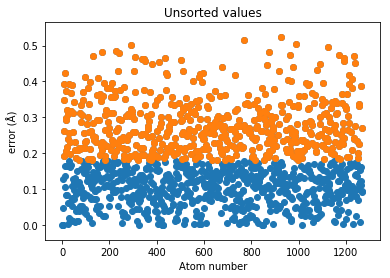

In [25]:
chart(average_error)

此為大於平均兩個標準差之誤差點

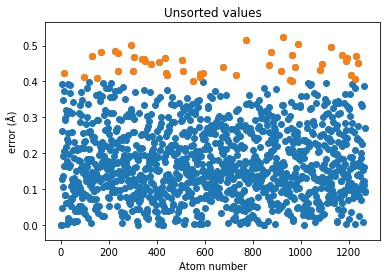

In [26]:
chart(average_error+2*sd)

找出上面是哪些值

In [28]:
error2sd = ans.error[ans.error.values>average_error+2*sd]

96      0.411
129     0.471
150     0.409
168     0.481
228     0.485
237     0.428
240     0.480
291     0.503
303     0.429
306     0.467
339     0.463
348     0.463
351     0.458
378     0.448
411     0.454
435     0.465
438     0.425
444     0.417
504     0.459
510     0.429
552     0.403
579     0.413
582     0.421
594     0.423
675     0.439
732     0.418
771     0.516
867     0.445
876     0.483
918     0.429
927     0.523
954     0.403
963     0.473
966     0.401
975     0.441
990     0.505
1080    0.432
1089    0.449
1125    0.495
1173    0.474
1191    0.458
1194    0.464
1212    0.417
1227    0.407
1233    0.469
1239    0.452
Name: error, dtype: float64

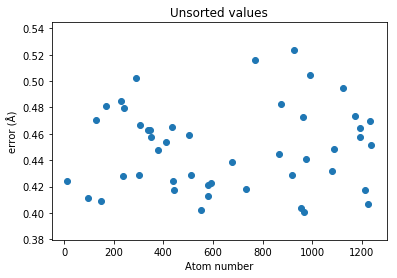

In [29]:
x = np.linspace(1, len(ans), len(ans))
y = ans.error.values

x2sd = x[y>average_error+2*sd]
y2sd = y[y>average_error+2*sd]

plt.scatter(x2sd, y2sd)
    
plt.xlabel("Atom number")
plt.ylabel("error (Å)")
plt.title("Unsorted values")

dir_error ={}
for i in range(1, len(x2sd)):
    #print(f"編號{int(x2sd[i])}之值為{y2sd[i]}")
    dir_error[int(x2sd[i])] = y2sd[i].round(decimals=3)

pd.Series(dir_error,name="error")

由以上結果可以發現誤差非常的平均，因此我推測應該是程式設計仍有瑕疵

Text(0.5, 1.0, 'sorted values')

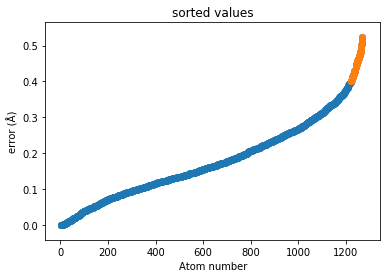

In [30]:
x = np.linspace(1, len(ans), len(ans))
y = ans.error.sort_values().values

x2 = x[y>average_error + 2*sd]
y2 = y[y>average_error + 2*sd]

plt.scatter(x, y)
plt.scatter(x2, y2)

plt.xlabel("Atom number")
plt.ylabel("error (Å)")
plt.title("sorted values")

In [31]:
sum(y[y>average_error + 2*sd])/len(y[y>average_error + 2*sd])

0.44935640252297954